In [1]:
import os
import sys
import re
import time
import datetime as dt
import string
import warnings
import subprocess
import logging
import numpy as np
import pandas as pd
import artm
from datetime import timedelta
from collections import Counter
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

%matplotlib inline


NUM_TOPICS = 60
local_data_dir = 'output'
date = "{}-{}-{}".format((dt.datetime.now()-dt.timedelta(1)).year,
                  str((dt.datetime.now()-dt.timedelta(1)).month) if len(str((dt.datetime.now()-dt.timedelta(1)).month)) == 2 else "0"+str((dt.datetime.now()-dt.timedelta(1)).month),
                  str((dt.datetime.now()-dt.timedelta(1)).day) if len(str((dt.datetime.now()-dt.timedelta(1)).day)) == 2 else "0"+str((dt.datetime.now()-dt.timedelta(1)).day))
print(date)

local_vw_file = 'paths.vw'

def read_data(path):
    df = pd.read_csv(path, nrows=80000)
    return df

def print_line_out(qid, text):
    """
    Converts text to vw format:
    $q_id token1:count1 token2:count2 etc...
    """
    line = " ".join("{}:{}".format(key.strip(), val) for (key, val) in Counter(text.lower().translate(str.maketrans('', '', string.punctuation)).replace(":","").split()).items() if len(key)>2 and key not in stopWords)
    return "q_{} {}".format(qid, line)

def check_or_create_local_data_dir_for_date(local_data_dir, date):
    local_dir = os.path.join(local_data_dir, date)
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    
def counters_to_local_file(path, col_id, col_text):
    """
    Loads preprocessed texts and converts them to a vw format
    """
    check_or_create_local_data_dir_for_date(local_data_dir, date)
    df = read_data(path)
    df[col_text] = df[col_text].fillna("UNK")
    df['vw'] = df[[col_id, col_text]].apply(lambda x: print_line_out(x[0], x[1]), 1)
    out_f = os.path.join(local_data_dir, date, local_vw_file)
    with open(out_f, "w") as f:
        for player in df['vw'].values:
            f.write(player+"\n")

def vw_to_artm_batches():
    """
    Input: vw file (vw formatting)
    Output: artm batches dir (locally)
    """
    check_or_create_local_data_dir_for_date(local_data_dir, date)
    in_path = os.path.join(local_data_dir, date, local_vw_file)
    out_path = os.path.join(local_data_dir, date, "batches")

    batch_vectorizer_train = artm.BatchVectorizer(data_path=in_path,
                                                  collection_name='code',
                                            data_format='vowpal_wabbit',
                                            target_folder=out_path)
    dictionary = batch_vectorizer_train.dictionary
    dictionary.filter(min_df=20)
    dictionary.filter(max_df=5000)
    dictionary.save_text(os.path.join(local_data_dir, date, "dictionary.txt"))

/Users/artemzraev/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/artemzraev/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
/Users/artemzraev/anaconda3/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Counter, Iterable


2019-11-04


### Загрузим датасет с заголовками, преобразуем тексты

In [2]:
counters_to_local_file("./articles.csv", "article_id", 'title')

### создадим специальные batch-файлы для ARTM (этого требует библиотека)

In [3]:
vw_to_artm_batches()

### Train ARTM

In [4]:
class TrainARTM():
    """
    Trains and saves an ARTM model, score results and theta matrix in local dir
    Output: artm model, scores, theta
    """
    
    def __init__(self, local_data_dir, date, n_topics, n_workers):
        self.local_data_dir = local_data_dir
        self.date = date
        self.n_topics = n_topics
        self.n_workers = n_workers

    def run(self):
        self.basedir = os.path.join(self.local_data_dir, self.date)
        in_dir_batches = os.path.join(self.local_data_dir, self.date, "batches")

        date_prev = None
        use_pretrained = False
        date_list = [date.strip() for date in os.listdir(self.local_data_dir)]
        print(date_list)
        if not date_list:
            raise IOError("Could not run a training. No batches found.")

        if len(date_list) == 1:
            date_prev = None
        else:
            try:
                date_prev = [date for date in date_list if date<self.date][-1]
            except IndexError as e:
                date_prev = date_list[-1]
            use_pretrained = True

        if date_prev:
            self.model_in_file = os.path.join(self.local_data_dir, date_prev, "artm.model")

        else:
            self.model_in_file = None

        self.model_out_file = os.path.join(self.basedir, "artm.model")

        dict_path = os.path.join(self.basedir, "dictionary.txt")
        dictionary = artm.Dictionary()
        dictionary.load_text(dict_path)

        self.batch_vectorizer = artm.BatchVectorizer(data_path=os.path.join(self.basedir, "batches"),
                                        data_format='batches')

        self._init_artm_model(dictionary)
        self._train(use_pretrained)
        self._save_results()
        
    def _init_artm_model(self, dictionary):
        """
        Init a new model, adding regularizers, scores
        """
        self.model = artm.ARTM(num_topics=self.n_topics,
                              cache_theta=True,
                              num_processors=self.n_workers,
                              show_progress_bars=True,
                              seed=12,
                              dictionary=dictionary)
        self._add_regularizers()
        self._add_scores()

    def _add_regularizers(self):
        """
        Add some regularizers to an ARTM model
        """
        self.model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))
        self.model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer'))

    def _add_scores(self):
        """
        Output: several png files with scores
        """
        self.model.scores.add(artm.PerplexityScore(name='my_fisrt_perplexity_score'))
        self.model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
        self.model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
        self.model.scores.add(artm.TopTokensScore(name='top_tokens', num_tokens=10))
                                                  
    def _train(self, use_pretrained):
        """
        Trains an ARTM model
        """
        if use_pretrained:
            print("Using pretrained model")
            #load model
            artm_old = artm.ARTM(self.n_topics)
            artm_old.load(self.model_in_file)

            #getting phi
            phi_old = artm_old.phi_
            #phi to update
            phi_to_update = self.model.get_phi()
            phi_to_update['term'] = phi_to_update.index
            phi_old['term'] = phi_old.index

            #updating weights
            phi_to_update.update(phi_old.drop_duplicates(subset='term', keep='last'), join='left', overwrite=True)
            phi_to_update = phi_to_update.drop('term', 1)

            (_, phi_ref) = self.model.master.attach_model(model=self.model.model_pwt)
            np.copyto(phi_ref, phi_to_update.values)
            num_collection_passes = 10
        else:
            print("Train from scratch")
            num_collection_passes = 70
            
        self.model.fit_offline(batch_vectorizer=self.batch_vectorizer,
                                   num_collection_passes=num_collection_passes)

    def _save_results(self):
        """
        Saves theta matrix (article_id -> topics) to a csv file.
        Then saves top_tokens for every class_id and finally dumps images of a perplexity score for every class.
        """
        self.model.theta_columns_naming='title'
        self.model.save(self.model_out_file)

        #theta = self.model.theta_
        theta = self.model.get_theta()
        theta = theta.T
        theta['player_id'] = theta.index
        theta = theta.drop_duplicates(subset='player_id')
        theta['dt'] = self.date
        topic_columns = ["topic_{}".format(col) for col in range(self.n_topics)]
        theta.to_csv(os.path.join(self.basedir, 'theta.csv'), index=None)
        top_tokens = self.model.score_tracker['top_tokens']
        top_tokens = pd.DataFrame(top_tokens.last_tokens)
        top_tokens.to_csv(os.path.join(self.basedir, "top_tokens.csv"))

### Проинициализируем наш объект для тренировки и запустим обучение

In [5]:
trainer = TrainARTM(local_data_dir, date, NUM_TOPICS, 4)

In [6]:
trainer.run()

['2019-11-04']
Train from scratch


Модель обучилась и сохранила результаты в локальный каталог

### Построим график перплексии

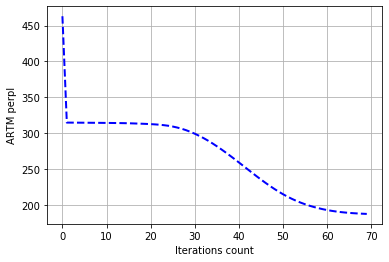

In [7]:
plt.plot(range(trainer.model.num_phi_updates), trainer.model.score_tracker['my_fisrt_perplexity_score'].value, 'b--',
         linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perpl')
plt.grid(True)
plt.savefig("./{}/{}/perplexity.png".format(local_data_dir, date))
plt.show()

### Разреженность матрицы phi

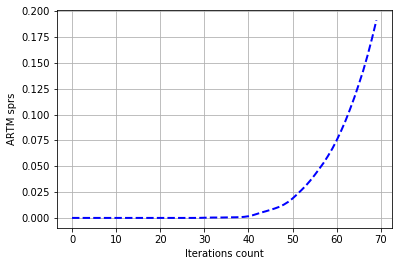

In [8]:
plt.plot(range(trainer.model.num_phi_updates), trainer.model.score_tracker['sparsity_phi_score'].value, 'b--',
         linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM sprs')
plt.grid(True)
plt.savefig("./{}/{}/sparsity_phi.png".format(local_data_dir, date))
plt.show()

Разреженность выглядит не очень - нужно больше итераций

### Топ слова по каждой тематике

In [9]:
topwords = pd.read_csv("./{}/{}/top_tokens.csv".format(local_data_dir, date)).drop("Unnamed: 0", 1)
topwords

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_50,topic_51,topic_52,topic_53,topic_54,topic_55,topic_56,topic_57,topic_58,topic_59
0,life,still,support,one,gun,back,real,may,trump,market,...,three,study,people,family,top,week,use,school,women,need
1,way,would,dead,game,students,keep,die,air,president,national,...,league,season,claims,feb,government,home,military,florida,better,know
2,want,iran,law,free,court,crisis,inside,part,former,global,...,super,food,sexual,face,child,show,line,high,tech,things
3,kids,even,dies,daily,war,teen,return,brexit,race,sales,...,awards,ways,amid,brain,water,photos,sign,county,online,company
4,made,little,trailer,guide,case,across,training,mexico,california,key,...,going,park,hits,digital,near,social,minister,student,today,heres
5,david,give,girl,come,ban,workers,drug,stay,donald,industry,...,rules,without,past,science,abuse,night,issues,push,days,start
6,really,doesnt,bitcoin,xbox,john,chicken,und,force,senate,growth,...,must,flu,continues,australia,nfl,instagram,warns,isnt,chief,talks
7,missing,coach,fund,plus,leader,cities,light,scott,campaign,analysis,...,visit,build,british,according,announced,dogs,questions,debate,full,space
8,move,teams,billy,rumors,challenge,mom,building,express,gop,players,...,list,many,late,helps,draft,celebrates,needs,hes,tuesday,never
9,looking,two,age,class,assault,card,success,relationship,policy,forecast,...,cup,internet,low,sea,poll,stories,justice,lawmakers,available,model


### Nearest neighbors

Посчитаем топ k ближайших соседей и посмотрим на них

In [10]:
def get_nn_title(title, src_emb, src_id2title, tgt_emb, tgt_id2title, K=5):                                        
    print("Nearest neighbors of \"%s\":" % title)                                                                      
    title2id = {v: k for k, v in src_id2title.items()}
    title_emb = src_emb[title2id[title]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(title_emb / np.linalg.norm(title_emb))
    k_best = scores.argsort()[-K:][::-1]                                                     
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2title[idx]))

Загружаем матрицу theta (топики документов, которые мы выше посчитали с помощью ARTM)

In [11]:
theta = pd.read_csv("./output/2019-11-04/theta.csv")
theta['article_id'] = theta['player_id'].apply(lambda x: x.split("_")[1], 1)
df = read_data("articles.csv")
df['article_id'] = df['article_id'].astype(str)
df.head(3)

,Unnamed: 0,article_id,title
0,0,372684348,Why Software Is Crucial For Facebook's Vision ...
1,1,379646855,Apple's Next iPhone Is Shaping Up to Be a Big ...
2,2,383358395,Would YOU spend £500 on AirPods? Apple's wirel...


In [12]:
df = pd.merge(df[['article_id', 'title']], theta, on='article_id')

Сделаем список заголовков и список номеров, а после объединим их в словарь

In [13]:
titles = df['title'].values
qids = range(len(titles))
question_dict = dict(zip(qids, titles))

Создадим список из наших artm топиков для каждого заголовка

In [14]:
embeddings = df[[col for col in df.columns if "topic" in col]].values

### посмотрим на случайно выбранные заголовки и на ближайшие к ним

In [15]:
for i in [1, 2, 7, 5001, 15002]:
    get_nn_title(titles[i], 
             np.array(embeddings), 
             question_dict, np.array(embeddings), question_dict, 10)

Nearest neighbors of "Apple's Next iPhone Is Shaping Up to Be a Big Update":
1.0000 - Apple's Next iPhone Is Shaping Up to Be a Big Update
0.9943 - Why Is Twitter Discontinuing App For Mac Devices
0.9943 - Update: FabFilter Updates All Plug-ins with Improvements and Bug Fixes
0.9943 - Apple removes secretive Telegram messaging app from App Store
0.9943 - Download macOS 10.13.4 Beta 2 [Developers Only]
0.9904 - Axiom fixes fender fitting problems with Axle, Disc & Frame Runner mounts
0.9904 - Mesa 17.3.5 Released To Fix A RADV Bug
0.9904 - App Builder Appy Pie Out of Beta on iTunes
0.9899 - How To Downgrade iOS 11.2.6 On iPhone, iPad, iPod touch
0.9899 - Apple releases macOS 10.13.4 beta 3 for developers
Nearest neighbors of "Would YOU spend £500 on AirPods? Apple's wireless earphones are selling for three times their retail price on eBay":
1.0000 - Would YOU spend £500 on AirPods? Apple's wireless earphones are selling for three times their retail price on eBay
0.9744 - Best Chromebox 